In [5]:

from ticers import Ticers
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  

#t = Ticers()
#t.dowload_data('GAZP', '2022-01-01', '2022-12-01')
p = pd.read_csv('./data/company/GAZP_D1.csv')

# Индексируем поле Data
p.set_index('Date', inplace=True)

# Переводим текстоый формат в datetime для удобного проведения срезов
p.index = pd.to_datetime(p.index)
gazp_open = p['Open']
gazp_open

Date
2006-01-23    239.00
2006-01-24    220.50
2006-01-25    225.20
2006-01-26    228.90
2006-01-27    226.20
               ...  
2022-03-25    263.99
2022-03-28    225.25
2022-03-29    220.00
2022-03-30    211.02
2022-03-31    218.98
Name: Open, Length: 4042, dtype: float64

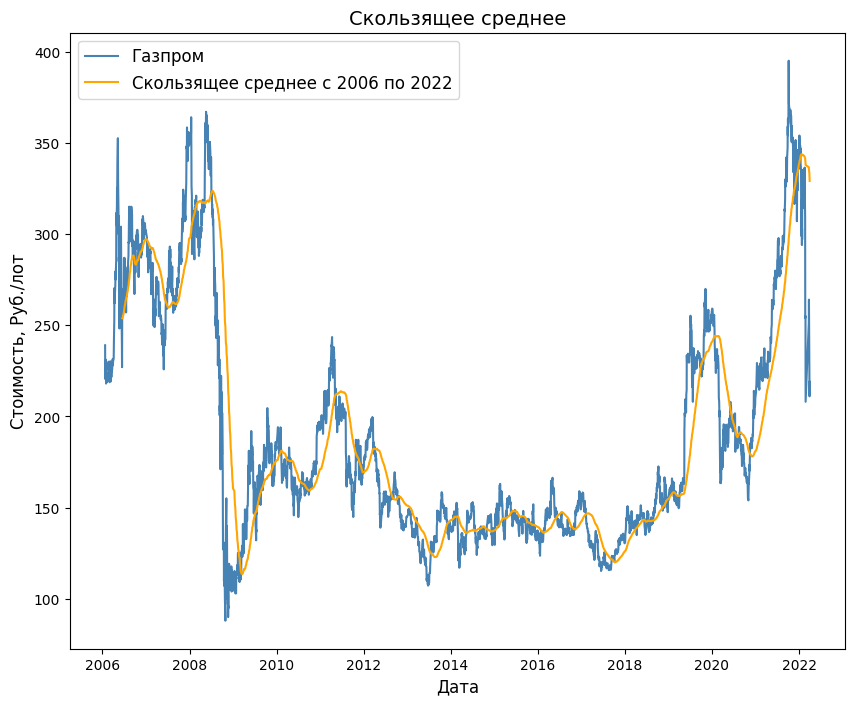

In [6]:
plt.figure(figsize = (10,8))
plt.plot(gazp_open, label = 'Газпром', color = 'steelblue')

# window - наблудение через кажные 12 дней
plt.plot(gazp_open.rolling(window = 100).mean(), label = 'Скользящее среднее с 2006 по 2022', color = 'orange')
plt.legend(title = '', loc = 'upper left', fontsize = 12)

# добавим подписи к осям и заголовки
plt.xlabel('Дата', fontsize = 12)
plt.ylabel('Стоимость, Руб./лот', fontsize = 12)
plt.title('Скользящее среднее', fontsize = 14)

plt.show()

In [7]:
from pmdarima import auto_arima

# обучающая выборка будет включать данные до декабря 1959 года включительно
train = gazp_open['2020-01':'2021-12']
# тестовая выборка начнется с января 1960 года (по сути, один год)
test = gazp_open['2022':]

# настроим поиск параметров на обучающей выборке
parameter_search = auto_arima(train, start_p = 1, start_q = 1, max_p = 3, max_q = 3, m = 12, start_P = 0, seasonal = False,
                         d = None, D = 1, trace = True, error_action ='ignore', suppress_warnings = True,  stepwise = True)           #
  
# выведем результат
print(parameter_search.summary())

c:\Users\Кирилл\Desktop\учеба\python\labs\ITOG\web_app\venv\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=3376.834, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=3242.593, Time=0.07 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=3374.834, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=3161.856, Time=0.08 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=3105.350, Time=0.10 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.54 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=3103.351, Time=0.07 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=3159.856, Time=0.04 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=3007.714, Time=0.15 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=3005.715, Time=0.13 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=3007.910, Time=0.12 sec
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=3007.715, T

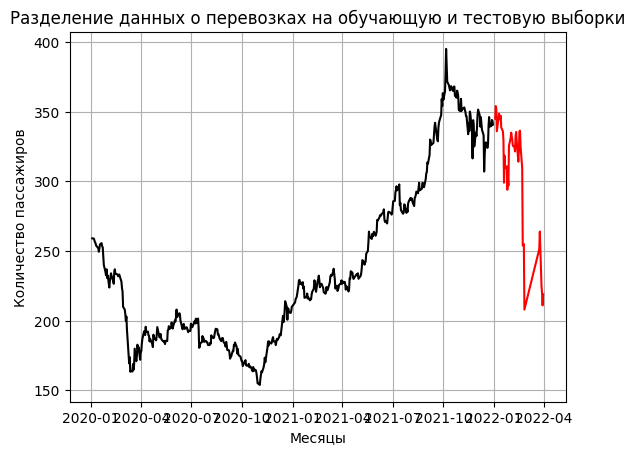

In [8]:
plt.plot(train, color = "black")
plt.plot(test, color = "red")
 
# заголовок и подписи к осям
plt.title('Разделение данных о перевозках на обучающую и тестовую выборки')
plt.ylabel('Количество пассажиров')
plt.xlabel('Месяцы')
 
# добавим сетку
plt.grid()
 
plt.show()

In [9]:
# принудительно отключим предупреждения системы
import warnings
warnings.simplefilter(action = 'ignore', category = Warning)
 
# обучим модель с соответствующими параметрами, SARIMAX(3, 0, 0)x(0, 1, 0, 12)
# импортируем класс модели
from statsmodels.tsa.statespace.sarimax import SARIMAX
 
# создадим объект этой модели
model = SARIMAX(train, 
                order = (2, 2, 1), 
                seasonal_order = (0, 0, 0, 0))
 
# применим метод fit
result = model.fit()

In [10]:
# тестовый прогнозный период начнется с конца обучающего периода
start = len(train)
 
# и закончится в конце тестового
end = len(train) + len(test) - 1
  
# применим метод predict
predictions = result.predict(start, end)
predictions

505    341.349835
506    341.922762
507    342.195134
508    342.490278
509    342.811593
510    343.129042
511    343.444339
512    343.760138
513    344.076101
514    344.392007
515    344.707902
516    345.023802
517    345.339704
518    345.655604
519    345.971505
520    346.287406
521    346.603306
522    346.919207
523    347.235108
524    347.551009
525    347.866909
526    348.182810
527    348.498711
528    348.814612
529    349.130512
530    349.446413
531    349.762314
532    350.078215
533    350.394115
534    350.710016
535    351.025917
536    351.341818
537    351.657718
538    351.973619
539    352.289520
540    352.605421
541    352.921321
542    353.237222
543    353.553123
544    353.869024
545    354.184924
546    354.500825
547    354.816726
548    355.132626
Name: predicted_mean, dtype: float64

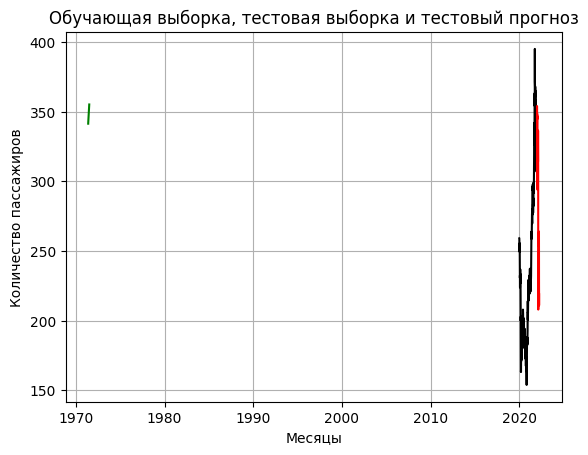

In [11]:
# выведем три кривые (обучающая, тестовая выборка и тестовый прогноз)
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.plot(predictions, color = "green")
 
# заголовок и подписи к осям
plt.title("Обучающая выборка, тестовая выборка и тестовый прогноз")
plt.ylabel('Количество пассажиров')
plt.xlabel('Месяцы')
 
# добавим сетку
plt.grid()
 
plt.show()